#### This notebook is used to train a character recongition from input image using MobileNets 

In [1]:
# ignore warning 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizer_v2.adam import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np

### Visualize dataset

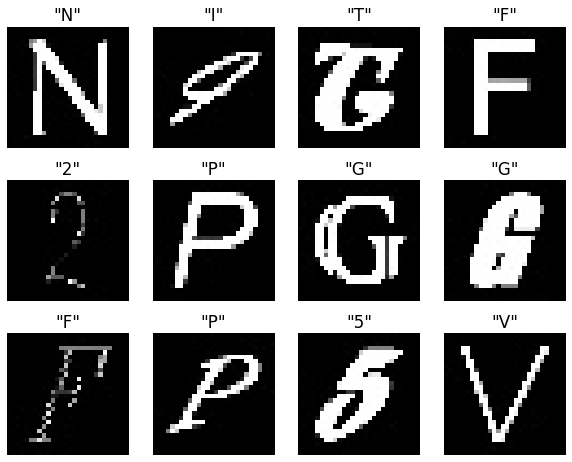

In [2]:
dataset_paths = glob.glob("dataset_characters/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("Visualize_dataset.jpg",dpi=300)    


## Data pre-processing

In [3]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes.npy', lb.classes_)

[INFO] Find 37623 images with 36 classes


In [0]:
# split 10% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [0]:
# data augumentation
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

## Initialize MobileNets architecture with pre-trained weight

In [ ]:
# Create our model with pre-trained MobileNetV2 architecture from imagenet
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    baseModel = MobileNetV2(weights="imagenet",
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
        # compile model
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

In [10]:
# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 30

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step


## Train model

In [11]:
BATCH_SIZE = 64

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="License_character_recognition.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/30
486/486 [==============================] - 147s 303ms/step - loss: 1.5441 - accuracy: 0.5989 - val_loss: 1.5866 - val_accuracy: 0.6090

Epoch 00001: saving model to License_character_recognition.h5
Epoch 2/30
486/486 [==============================] - 124s 256ms/step - loss: 0.4201 - accuracy: 0.8930 - val_loss: 0.4698 - val_accuracy: 0.8788

Epoch 00002: saving model to License_character_recognition.h5
Epoch 3/30
486/486 [==============================] - 125s 258ms/step - loss: 0.2769 - accuracy: 0.9281 - val_loss: 0.2617 - val_accuracy: 0.9352

Epoch 00003: saving model to License_character_recognition.h5
Epoch 4/30
486/486 [==============================] - 125s 257ms/step - loss: 0.2103 - accuracy: 0.9454 - val_loss: 0.1744 - val_accuracy: 0.9563

Epoch 00004: saving model to License_character_recognition.h5
Epoch 5/30
486/486 [==============================] - 126s 259ms/step - loss: 0.1642 - accuracy: 0.9554 - val_loss: 0.1491 - val_accuracy: 0.9592

Epoch 00005: savi

## Visualize training result

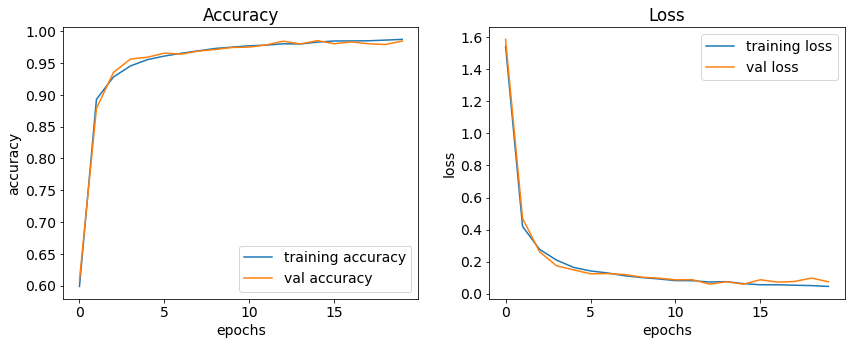

In [14]:

fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#plt.savefig("Training_result.jpg",dpi=300)

In [0]:
# save model architectur as json file
model_json = model.to_json()
with open("MobileNets_character_recognition.json", "w") as json_file:
  json_file.write(model_json)

## The End!